#### **AUTOMATIC EXTRACTION OF TEXT**
In this notebook, we aim to identify the most effective approach for automatically extracting text from images of key documents required to complete an accident report. Specifically, we focus on:

- Driver’s license

- Identity card (ID)

- License plate

These are essential components in the initial steps of reporting a vehicle-related incident. Although a document from the insurance company is also necessary, we have temporarily excluded it from this analysis due to privacy considerations.

Our goal is to evaluate tools that can reliably extract structured text from these documents to enable automated form filling.

### **Input Data Used**

#### **1 Identity Card ID**



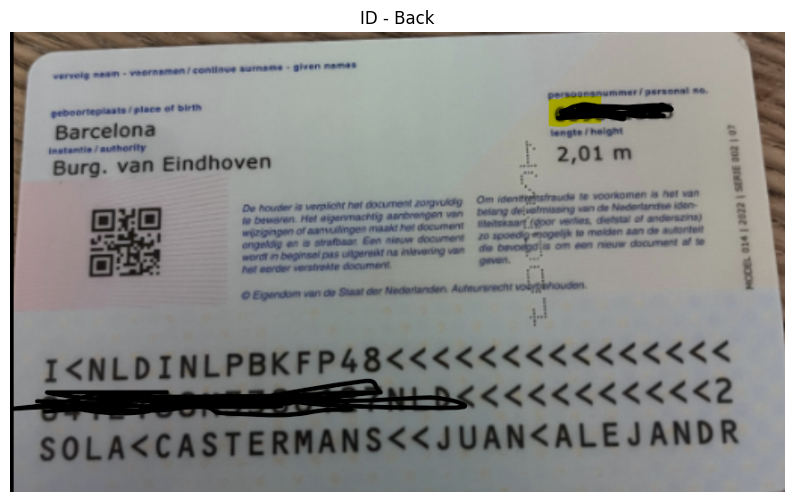

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Image paths
image_paths = [
    "../Accident Report/IdAlecFront.png",
    "../Accident Report/IdAlecBack.png"
]

# Display each image
for i, path in enumerate(image_paths):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"ID - {'Front' if i == 0 else 'Back'}")
    plt.show()

#### **2 License Plate**

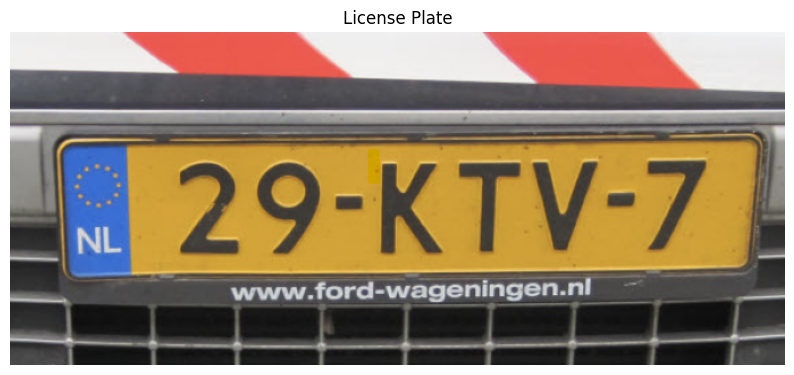

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the image (in BGR format)
image_path = "../Accident Report/LicensePlateExample1.png"
img = cv2.imread(image_path)

# Convert to RGB for correct display in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("License Plate")
plt.show()


#### **3 Drivers License**

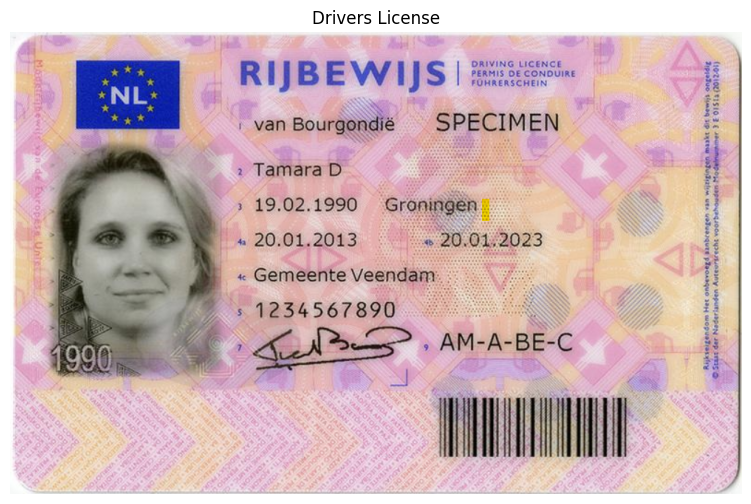

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the image (in BGR format)
image_path = "../Accident Report/DriversLicenseExample1.png"
img = cv2.imread(image_path)

# Convert to RGB for correct display in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Drivers License")
plt.show()


## **Tesseract OCR vs Microsoft Azure Form Recognizer**

As following each input will use these pre-trained models and the results will be compared.  

**1 = ID**

**2 = License Plate**

**3 = Drivers License**

### **1 (OCR, Alec)**

This Python script processes images of Alec's Dutch ID card (front and back) to extract structured information. 

It first reads and preprocesses each image using OpenCV to reduce noise, and apply adaptive thresholding for better text visibility. Each preprocessed image is then displayed using matplotlib, allowing us to analyze it. Tesseract OCR (with Dutch and English languages) is used to extract raw text from the images, which is cleaned and normalized to reduce typical OCR errors. The script then parses that text to extract relevant identity fields such as full name, place of birth, BSN (citizen service number), document number, and key dates (birth, issue, expiry). These fields are collected into a dictionary and printed as structured JSON output. 

Finally, both the raw OCR text and the structured fields are saved to disk.

In [11]:
import cv2
import pytesseract
import numpy as np
import re
import json
import os
import matplotlib.pyplot as plt

# Paths to images
image_paths = [
    "../Text Extraction/IdAlecFront.png",
    "../Text Extraction/IdAlecBack.png"
]

# Output files
output_txt = r"C:/Users/solaa/SEM6/AI-Damage-Reports/Text Extraction/extracted_id_text.txt"
output_json = r"C:/Users/solaa/SEM6/AI-Damage-Reports/Text Extraction/extracted_id_data.json"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Image not found: {image_path}")

    height, width = img.shape[:2]

    # Keep central 40% horizontally (adjust percentages if needed)
    left = int(width * 0.35)
    right = int(width * 0.65)
    cropped = img[:, left:right]  # full height, cropped width

    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub(r'[0O]', 'O', text)
    text = re.sub(r'[1I]', 'I', text)
    text = re.sub(r'\bIUN\b', 'JUN', text, flags=re.IGNORECASE)
    text = re.sub(r'\bDEC/DEC\b', 'DEC', text)
    text = re.sub(r'\bJUN/JUN\b', 'JUN', text)
    return text

def extract_fields(text):
    fields = {}
    text = clean_text(text)

        # --- FULL NAME SPLIT: first name + full name (upper) ---
    surname = None
    given_names = None

    # Extract surname
    surname_match = re.search(r'(?:naam|surname)[^\w]*([^\d:\/\n\r]+?)(?=(voornamen|given names|geslacht|sex|$))', text, re.IGNORECASE)
    if surname_match:
        surname = surname_match.group(1)
        surname = re.sub(r'\b(surname|voornamen|given names|geslacht)\b', '', surname, flags=re.IGNORECASE).strip()

    # Extract given names
    given_names_match = re.search(r'(?:voornamen|given names)[^\w]*([^\d:\/\n\r]+?)(?=(geslacht|sex|$))', text, re.IGNORECASE)
    if given_names_match:
        given_names = given_names_match.group(1)
        given_names = re.sub(r'\b(surname|voornamen|given names|geslacht)\b', '', given_names, flags=re.IGNORECASE).strip()

    if given_names:
        fields["IDfirst_name"] = given_names.title()
    if given_names and surname:
        full_name = f"{given_names} {surname}"
        fields["IDname"] = full_name.upper()


    # --- Date of Birth (next line after the label) ---
    lines = text.splitlines()
    for i, line in enumerate(lines):
        if re.search(r'\bgeboortedatum\b|\bdate of birth\b', line, re.IGNORECASE):
            if i + 1 < len(lines):
                next_line = clean_text(lines[i + 1])

                # General fix: replace duplicated month like "JAN/JAN" -> "JAN"
                next_line = re.sub(r'\b([A-Z]{3})/\1\b', r'\1', next_line, flags=re.IGNORECASE)

                date_match = re.search(r'(\d{1,2})\s+([A-Z]{3})\s+(\d{4})', next_line)
                if date_match:
                    day, month, year = date_match.groups()
                    fields["date_of_birth"] = f"{int(day):02d} {month.upper()} {year}"
            break

    # Sex and nationality
    for line in lines:
        if re.search(r'(geslacht|sex).*?(nationaliteit|nationality)', line, re.IGNORECASE):
            tokens = clean_text(line).split()
            for t in tokens:
                if t in ['M', 'F', 'M/M', 'V', 'V/V']:
                    fields['sex'] = t.replace("/", "")
                elif t.lower().startswith("neder"):  # Nederlandse
                    fields['nationality'] = "Nederlandse"
            break

    return fields


# --- MAIN ---
all_text = ""

# Ensure output directory exists
os.makedirs(os.path.dirname(output_txt), exist_ok=True)

with open(output_txt, "w", encoding="utf-8") as f:
    for path in image_paths:
        try:
            processed_img = preprocess_image(path)
        except ValueError as e:
            print(str(e))
            continue

        # Save preprocessed image
        plt.figure(figsize=(10, 6))
        plt.imshow(processed_img, cmap='gray')
        plt.axis('off')
        plt.title(f"Preprocessed - {os.path.basename(path)}")
        plt.savefig(f"preprocessed_{os.path.basename(path)}.png")
        plt.close()

        # OCR
        custom_config = r'--oem 3 --psm 6 -c preserve_interword_spaces=1'
        text = pytesseract.image_to_string(
            processed_img, config=custom_config, lang='nld+eng'
        ).strip()

        # Save and print text
        f.write(f"--- Text from {os.path.basename(path)} ---\n{text}\n\n")
        print(f" Processed {os.path.basename(path)}:\n{text}\n")

        all_text += "\n" + text

# Extract structured fields
extracted_fields = extract_fields(all_text)

# Show extracted fields
print(" Extracted Fields:")
print(json.dumps(extracted_fields, indent=2, ensure_ascii=False))

# Save to JSON
with open(output_json, "w", encoding="utf-8") as jf:
    json.dump(extracted_fields, jf, indent=2, ensure_ascii=False)

print(f"\nText saved to: {output_txt}")
print(f"JSON saved to: {output_json}")



 Processed IdAlecFront.png:
as KONINKAIUS |

KINGDOM OF THE NETHERLAN

IDENTITY CARD

naam/surname

Sola Castermans

voornamen / given names

Juan Alejandro

geslacht/sex   natlonalttelt / nationality

M/M    Nederlandse

geboortedatum / date of birth

18 DEC/DEC 2004

Jatum van afglfte/date of Issue

12 JUN/JUN 2023

jeldig tot/date of expiry

12 JUN/JUN 2033

642944 ie
$        P

 Processed IdAlecBack.png:
e - given names                      *

der is verplicht het document zorgvuldig Om i
ven. Het eigenmachtig aanbrengen van belan
gen of aanvuilingen maakt het document _ titelts
g en is strafbaar. Een nieuw document ZO sp
) beginsel pas ultgereikt na inlevering van die b
fer verstrekte document.                               gavel
idom van de Staat der Nederlanden. Auteursreci
KF P4B<<<<<:
16142 7NLD<<:

 Extracted Fields:
{
  "IDfirst_name": "Juan Alejandro",
  "IDname": "JUAN ALEJANDRO SOLA CASTERMANS",
  "sex": "MM",
  "nationality": "Nederlandse"
}

Text saved to: C:/Users/sol

In [2]:
import re

# Tesseract's raw output text
text_front = """
NEDERLANDSE       m= KONINKRIJK DER NEDERLANDEN
(Di Ni  f  EF  -      9T KINGDOM OF THE NETHERLANDS    ROYAUME DES PAYS-BAS
DEN TH ut  FESKAART IDENTITY CARD                         CARTE D'IDENTITE
ern                                                                      documentnummer / document no.
j                                     INLPBKFP4
GD i         ae  naam/ surname
N a       ‚ Sola Castermans
=        2              | _ yoornamen/ given names
yy     b   =   £ Juan Alejandro
| d        á          a   _ geslacht/sex _ nationaliteit /nationality
ä_       .           = M/M      Nederlandse                           ë
Be     Cc      I geboortedatum/ date of birth                  á
n             ‚ 18 DEC/DEC 2004        i
syed                  n           i datum van afgifte/ date of issue                    Sa     -                            ‚
SOA        @ 12 JUN/JUN 2023       k
2 IU ‘a            ~~ geldig bess expiry                 D~ we
Hcerstening?z stucatiee       =     12 JUN/JUN 2033
=                642946 E
S            g         E N
"""

text_back = """
vervolg naam - voornamen’/ continue surname - given names                       g                                                          &
geboorteplaats / place of birth                                                                      persoonsnummer/ personal no.
Barcelona                                 659301325
instantie / authority                                                                     ‚ _ lengte/height                   5
Burg.  van Eindhoven                                   £ 2,01 m              3
 L- = = :  == = De houder is verplicht het document zorgvuldig Om iiaeas te voorkomen is het van       5
== _ te bewaren. Het eigenmachtig aanbrengen van   belang deivetmissing van de Nederlandse iden-        g
s     =  j= os t wijzigingen of aanvullingen maakt het document _ titeitskaart (door verlies, diefstal of anderszins)       S
e O ongeldig en is strafbaar. Een nieuw document 0 spoedig mogelijk te melden aan de autonieit       =
= ge wort in boginsel pas uitgereikt na inlevering van die bevoegdiis om een nieuw document af te       x
. i‚é__'îl;  het eerder verstrekte document.                geven.                                   5
S e e ohouden,                               f
I<NLDINLPBKF P48<<<<<<<<<<<<cc<
0412188M3306127NLD<<<<<<<<<<<2
SOLA<CASTERMANS<<JUAN<ALEJANDR
"""

# Dictionary to store extracted data
data = {}

# Document number
doc_number = re.search(r'documentnummer.*\n.*([A-Z0-9]{9})', text_front)
data['document_number'] = doc_number.group(1) if doc_number else None

# Surname
surname = re.search(r'naam/ surname\n.*?\s+([A-Za-z]+ [A-Za-z]+)', text_front)
data['surname'] = surname.group(1) if surname else None

# Given names
given_names = re.search(r'yoornamen/ given names\n.*?\s+([A-Za-z]+(?: [A-Za-z]+)*)', text_front)
data['given_names'] = given_names.group(1) if given_names else None

# Sex
sex = re.search(r'geslacht/sex.*=\s*([MF])', text_front)
data['sex'] = sex.group(1) if sex else None

# Nationality
nationality = re.search(r'nationaliteit /nationality\n?.*?([A-Za-z]+)', text_front)
data['nationality'] = nationality.group(1) if nationality else None

# Date of birth
dob = re.search(r'date of birth\s+.*?(\d{1,2} [A-Z]{3}/[A-Z]{3} \d{4})', text_front)
data['date_of_birth'] = dob.group(1) if dob else None

# Date of issue
issue = re.search(r'date of issue\s+.*?(\d{1,2} [A-Z]{3}/[A-Z]{3} \d{4})', text_front)
data['date_of_issue'] = issue.group(1) if issue else None

# Expiry date
expiry = re.search(r'expiry\s+.*?(\d{1,2} [A-Z]{3}/[A-Z]{3} \d{4})', text_front)
data['expiry_date'] = expiry.group(1) if expiry else None

# Place of birth
place = re.search(r'place of birth\s+([A-Za-z]+)', text_back)
data['place_of_birth'] = place.group(1) if place else None

# Personal number
pers_num = re.search(r'personal no.*?(\d{9})', text_back)
data['personal_number'] = pers_num.group(1) if pers_num else None

# Print results
for key, value in data.items():
    print(f"{key}: {value}")


document_number: INLPBKFP4
surname: Sola Castermans
given_names: b
sex: None
nationality: M
date_of_birth: None
date_of_issue: None
expiry_date: None
place_of_birth: persoonsnummer
personal_number: None


### **Results**

The results are not good, in fact, it is seen that the Extracted Fields are chaotic, even after much preprocessing. 

### **1 (Microsoft Azure Form Recognizer, Alec)**

In this code a resource has already been created in Azure allowing the code to be more straightforward than with OCR. 

In the output, the fieldnames are displayed and the percentage next to it represents how confident the model is that it correctly recognized and extracted that particular field. At the end, screenshots of the desktop results are presented as well. 




Processing Front of ID: IdAlecFront.png

 Extracted Fields from Front:
 - DateOfBirth: 2004-12-18 (85%)
 - DateOfExpiration: 2033-06-12 (85%)
 - DateOfIssue: 2023-06-12 (86%)
 - DocumentDiscriminator: 642944 (76%)
 - FirstName: Juan Alejandro (86%)
 - LastName: Sola Castermans (85%)
 - Sex: M (69%)

Processing Back of ID: IdAlecBack.png

 Extracted Fields from Back:
 - Height: 2,01 m (72%)
 - PlaceOfBirth: Barcelona (81%)


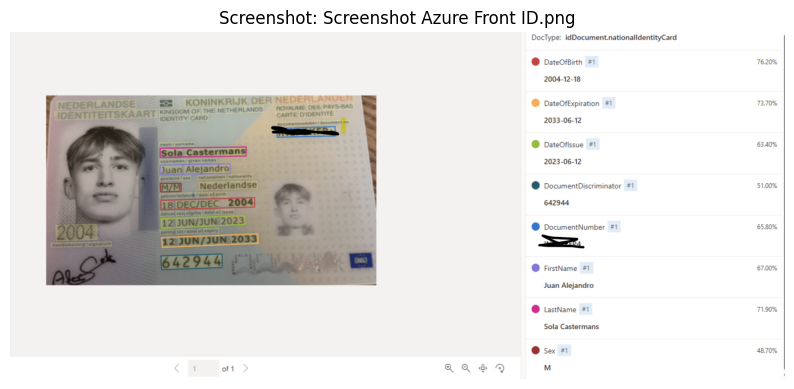

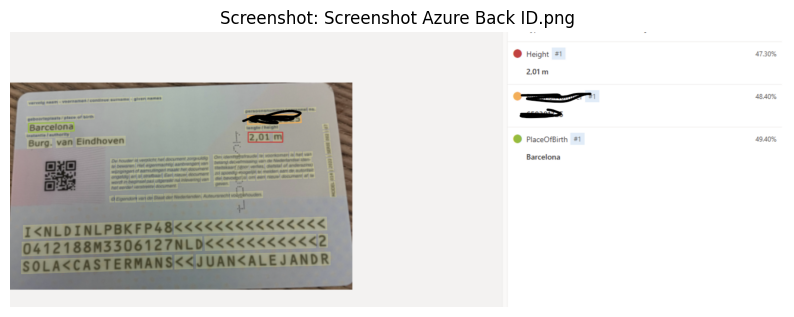

In [ ]:
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
import os
import matplotlib.pyplot as plt
import cv2

# Azure credentials
endpoint = "https://alpayalec1213.cognitiveservices.azure.com/"
key = "3LmBSsqqx9cxjH3abNllYrX6OpBsRqA4QxbmsxC4EoYmg5raJZrjJQQJ99BEACi5YpzXJ3w3AAALACOGQxzy"

# File paths for front and back of ID
image_paths = {
    "Front": "../Accident Report/IdAlecFront.png",
    "Back": "../Accident Report/IdAlecBack.png"
}

# Extra screenshots to display at the end
screenshots = [
    "../Accident Report/Screenshot Azure Front ID.png",
    "../Accident Report/Screenshot Azure Back ID.png"
]

# Initialize Azure Form Recognizer client
client = DocumentAnalysisClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

# Analyze each side of the ID
for side, path in image_paths.items():
    if not os.path.exists(path):
        print(f" File not found: {path}")
        continue

    print(f"\nProcessing {side} of ID: {os.path.basename(path)}")

    with open(path, "rb") as f:
        poller = client.begin_analyze_document("prebuilt-idDocument", document=f)
        result = poller.result()

    for doc in result.documents:
        print(f"\n Extracted Fields from {side}:")
        for name, field in doc.fields.items():
            value = field.value if field.value else "N/A"
            confidence = round(field.confidence * 100)
            print(f" - {name}: {value} ({confidence}%)")

# Show the screenshots at the end
for path in screenshots:
    if os.path.exists(path):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Screenshot: {os.path.basename(path)}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Screenshot not found: {path}")


#### **Results**

Much more convincing results with accurate field extraction. 

### **2 (OCR, Alpay)**

As of now, Azure does not offer a dedicated model for license plate recognition. Therefore, for this task, only Tesseract OCR will be used. 

While the overall process is similar to the one used for identity documents, it is simpler in this case, since we are only interested in extracting a single element: the license plate number. Because of this, the OCR configuration is specifically tuned for short, high-contrast alphanumeric text. As previously, the image is first preprocessed to reduce noise and enhance readability before performing text extraction.

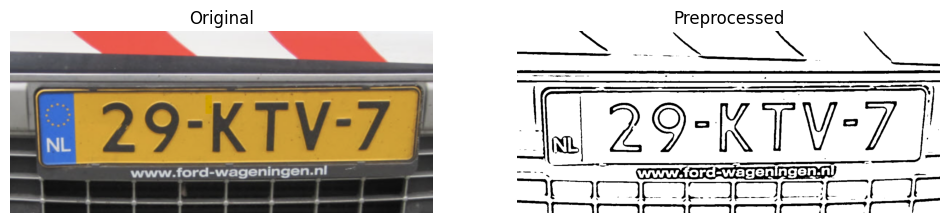

 PSM 6 extracted text: N29-KTV-7
ITE


In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os

image_path = "../Accident Report/LicensePlateExample1.png"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found!")

    # Resize
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Bilateral filter to reduce noise while preserving edges
    blur = cv2.bilateralFilter(gray, 11, 17, 17)

    # Adaptive threshold
    processed = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 31, 10
    )
    return img, processed

# Load original + preprocessed
original_img, processed_img = preprocess_image(image_path)

# Show both images
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed_img, cmap='gray')
plt.title("Preprocessed")
plt.axis("off")
plt.show()

configs = {
    "PSM 6": r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'
}

for label, config in configs.items():
    text = pytesseract.image_to_string(processed_img, config=config).strip()
    print(f" {label} extracted text: {text if text else ' No text detected'}")


#### **Results**

Preprocessed image looks not noisy at all and the extracted text is correct. 

### **3 (OCR, Alpay)**

This script processes an image of a Dutch driver's license. 

It begins by reading and converting the image to grayscale for preprocessing, which is then displayed for visual confirmation. It then applies regular expressions to identify and extract structured fields such as the license holder's name, date of birth, issue and expiry dates, license number, and vehicle categories. The extracted text is then printed to the console, saved as a plain text file, and the structured data is also stored in JSON format for further use. 

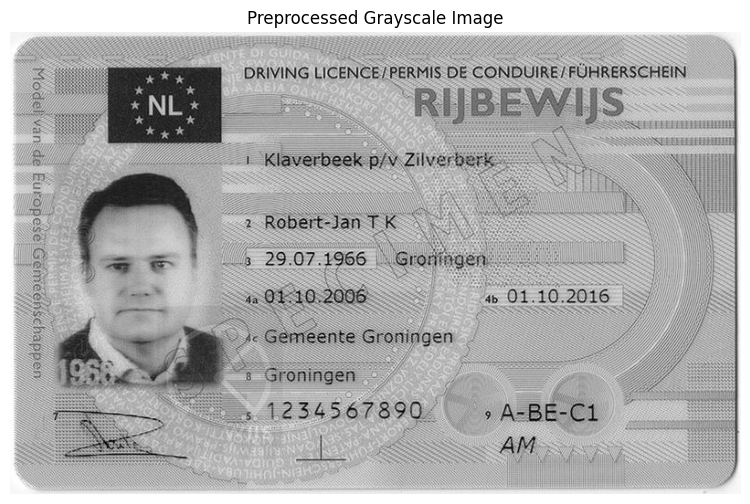

🪪 Full OCR Output:
z 7 ee DRIVING LICENCE/ PERMIS DE CONDUIRE/ FUHRERSCHEIN

3 2 RobertJanTK N

S ! 6 29.07.1966 | Grotingen U |

n „0f102006 w 01.10.2016 N )

5 ey oO Gemeente Groningen vy j ///

Sf ie “ Groningen ; Lf
a ee 1254567800; ABEL

📋 Extracted Fields:
{
  "name": "RobertJ",
  "date_of_birth": "29.07.1966",
  "issue_date": "01.10.2016",
  "license_number": "1254567800"
}

✅ Text saved to: ../Text Extraction/extracted_driverslicense_text.txt
✅ JSON saved to: ../Text Extraction/extracted_driverslicense_data.json


In [49]:
import cv2
import pytesseract
import numpy as np
import re
import json
import os
import matplotlib.pyplot as plt

# Input/output paths
image_path = "../Text Extraction/image.png"
output_txt = "../Text Extraction/extracted_driverslicense_text.txt"
output_json = "../Text Extraction/extracted_driverslicense_data.json"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Image not found: {image_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def extract_fields(text):
    fields = {}

    # Name (field 2): allow hyphens and initials
    name_match = re.search(r"\b2\s+([A-Z][a-z]+[-\s]?[A-Z]*\.?\s?[A-Z]*\.?)", text)
    if name_match:
        fields["name"] = name_match.group(1).strip()

    # Dates (birth, issue, expiry)
    all_dates = re.findall(r"\b\d{2}[./-]\d{2}[./-]\d{4}\b", text)
    if all_dates:
        fields["date_of_birth"] = all_dates[0]
        if len(all_dates) > 1:
            fields["issue_date"] = all_dates[1]
        if len(all_dates) > 2:
            fields["expiry_date"] = all_dates[2]

    # License number (9–10 digits)
    license_number = re.search(r"\b\d{9,10}\b", text)
    if license_number:
        fields["license_number"] = license_number.group(0)

    # Categories: A-BE-C1 + AM support
    cat_block = re.findall(r"\b(?:AM|A1?|BE?|B|C1?|D1?|T)\b(?:[-\s]*(?:AM|A1?|BE?|B|C1?|D1?|T))*", text)
    if cat_block:
        flat = ' '.join(cat_block).replace('\n', ' ').replace('-', ' ')
        codes = re.findall(r'\b(?:AM|A1?|BE?|B|C1?|D1?|T)\b', flat)
        seen = set()
        ordered = [c for c in codes if not (c in seen or seen.add(c))]
        fields["categories"] = '-'.join(ordered)

    return fields

# --- MAIN ---

# Preprocess
processed = preprocess_image(image_path)

# Show preprocessed image
plt.figure(figsize=(10, 6))
plt.imshow(processed, cmap='gray')
plt.title("Preprocessed Grayscale Image")
plt.axis('off')
plt.show()

# OCR config: layout mode 6 (uniform block), Dutch + English
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(processed, config=custom_config, lang='nld+eng').strip()

# Print full OCR
print("🪪 Full OCR Output:\n" + text + "\n")

# Extract fields
fields = extract_fields(text)
print("📋 Extracted Fields:")
print(json.dumps(fields, indent=2))

# Save outputs
with open(output_txt, "w", encoding="utf-8") as f:
    f.write(text)

with open(output_json, "w", encoding="utf-8") as jf:
    json.dump(fields, jf, indent=2)

print(f"\n✅ Text saved to: {output_txt}")
print(f"✅ JSON saved to: {output_json}")   


#### **Results**

The preprocessed image looks good and the results are solid. 

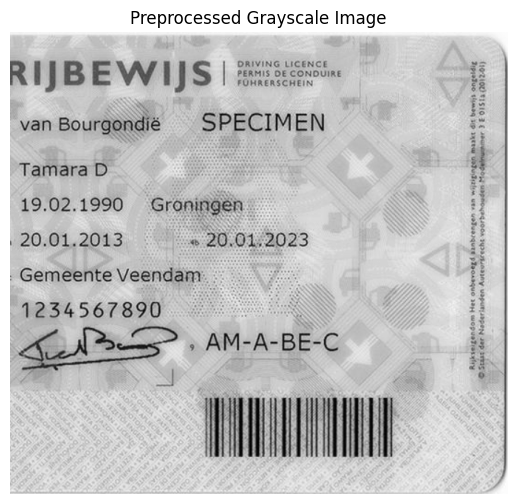

🪪 Full OCR Output:
RIJBEWIJS | E
van Bourgondië __SPECIMEN
Tamara D
19.02.1990 Groningen j

20.01.2013 « 20,01,2023

Gemeente Veendam fs if
1234567890
Gs ‚ AM-A-BE-C ä

e :

📋 Extracted Fields:
{
  "first_name": "Tamara D",
  "name": "TAMARA D VAN BOURGONDI\u00cb",
  "date_of_birth": "19.02.1990",
  "issue_date": "20.01.2013",
  "expiry_date": "20,01,2023",
  "license_number": "1234567890",
  "categories": "AM-A-BE-C"
}

✅ Text saved to: ../riverslicense_text.txt
✅ JSON saved to: ../extracted_driverslicense_data.json


In [9]:
import cv2
import pytesseract
import numpy as np
import re
import json
import os
import matplotlib.pyplot as plt

# Input/output paths
image_path = "../Text Extraction/DriversLicenseExample1.png"
output_txt = "../riverslicense_text.txt"
output_json = "../extracted_driverslicense_data.json"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Image not found: {image_path}")
    
    height, width = img.shape[:2]

    # Crop left side (remove photo zone ~32%)
    cropped = img[:, int(width * 0.32):]

    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    return gray

def extract_fields(text):
    fields = {}
    lines = text.splitlines()
    lines = [line.strip() for line in lines if line.strip()]

    # --- NAME ---
    name_line_1 = None
    name_line_2 = None

    for i, line in enumerate(lines):
        # Surname line: "van Bourgondië"
        if not name_line_1 and re.search(r'\bvan\b\s+[A-Z][a-z]+', line, re.IGNORECASE):
            name_line_1 = line.strip()
        # First name + initial: "Tamara D"
        elif not name_line_2 and re.match(r'^[A-Z][a-z]+ [A-Z]\.?$', line):
            name_line_2 = line.strip()

        if name_line_1 and name_line_2:
            full_name = f"{name_line_2} {name_line_1}".replace("__SPECIMEN", "").strip()
            fields["first_name"] = name_line_2.strip()
            fields["name"] = full_name.upper() # Full name with proper accents



        # --- DATES (more robust handling) ---
    date_pattern = r"\b\d{2}[\./,-]\d{2}[\./,-]\d{4}\b"
    all_dates = []
    for line in lines:
        found_dates = re.findall(date_pattern, line)
        if len(found_dates) >= 2:
            all_dates.extend(found_dates)
        elif len(found_dates) == 1:
            all_dates.append(found_dates[0])

        # Handle lines with a connector like "«" or "->" between two dates
        if re.search(rf"{date_pattern}\s*[«\-→]\s*{date_pattern}", line):
            found = re.findall(date_pattern, line)
            if len(found) == 2:
                all_dates.extend(found)

    # Deduplicate in case of duplicate detection
    all_dates = list(dict.fromkeys(all_dates))

    if len(all_dates) >= 1:
        fields["date_of_birth"] = all_dates[0]
    if len(all_dates) >= 2:
        fields["issue_date"] = all_dates[1]
    if len(all_dates) >= 3:
        fields["expiry_date"] = all_dates[2]



    # --- LICENSE NUMBER ---
    license_number = re.search(r"\b\d{9,10}\b", text)
    if license_number:
        fields["license_number"] = license_number.group(0)

    # --- CATEGORIES ---
    valid_categories = ['AM', 'A1', 'A', 'BE', 'B', 'C1', 'C', 'D1', 'T']
    found = re.findall(r'\b[A-Z]{1,3}\b', text)

    codes = [c for c in found if c in valid_categories]
    seen = set()
    ordered = [c for c in codes if not (c in seen or seen.add(c))]

    if ordered:
        fields["categories"] = '-'.join(ordered)

    return fields

# --- MAIN ---

# Preprocess
processed = preprocess_image(image_path)

# Show preprocessed image
plt.figure(figsize=(10, 6))
plt.imshow(processed, cmap='gray')
plt.title("Preprocessed Grayscale Image")
plt.axis('off')
plt.show()

# OCR config: layout mode 6 (uniform block), Dutch + English
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(processed, config=custom_config, lang='nld+eng').strip()

# Print full OCR
print("🪪 Full OCR Output:\n" + text + "\n")

# Extract fields
fields = extract_fields(text)
print("📋 Extracted Fields:")
print(json.dumps(fields, indent=2))

# Save outputs
with open(output_txt, "w", encoding="utf-8") as f:
    f.write(text)

with open(output_json, "w", encoding="utf-8") as jf:
    json.dump(fields, jf, indent=2)

print(f"\n✅ Text saved to: {output_txt}")
print(f"✅ JSON saved to: {output_json}")


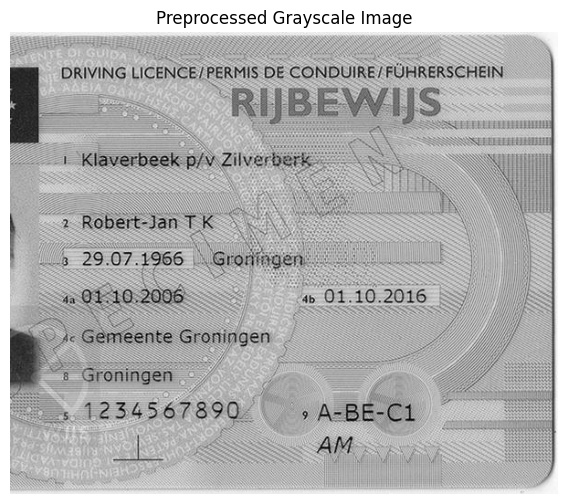

🪪 Full OCR Output:
m DRIVING Llcerìcsnïm«ns DECONDUREHURRESCHEN |
— RIJBEWIJS
24 e SSE ETE
A …P/—Ù\Z verbag;« SS T ll
| 4 29.07.1966 “Grodingen een N
5: Gemeente Groningen i / 7////
1234567890 A

📋 Extracted Fields:
{
  "date_of_birth": "29.07.1966",
  "license_number": "1234567890",
  "categories": "A-T"
}

✅ Text saved to: ../image_text.txt
✅ JSON saved to: ../image_driverslicense_data.json


In [4]:
import cv2
import pytesseract
import numpy as np
import re
import json
import os
import matplotlib.pyplot as plt

# Input/output paths
image_path = "../Text Extraction/image.png"
output_txt = "../image_text.txt"
output_json = "../image_driverslicense_data.json"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Image not found: {image_path}")
    
    height, width = img.shape[:2]

    # Crop left side (remove photo zone ~32%)
    cropped = img[:, int(width * 0.25):]

    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    return gray

def extract_fields(text):
    fields = {}
    lines = text.splitlines()
    lines = [line.strip() for line in lines if line.strip()]

    # --- NAME ---
    name_line_1 = None
    name_line_2 = None

    for i, line in enumerate(lines):
        # Surname line: "van Bourgondië"
        if not name_line_1 and re.search(r'\bvan\b\s+[A-Z][a-z]+', line, re.IGNORECASE):
            name_line_1 = line.strip()
        # First name + initial: "Tamara D"
        elif not name_line_2 and re.match(r'^[A-Z][a-z]+ [A-Z]\.?$', line):
            name_line_2 = line.strip()

    if name_line_1 and name_line_2:
        fields["name"] = f"{name_line_2} {name_line_1}"

    # --- DATES ---
    all_dates = re.findall(r"\b\d{2}[./-]\d{2}[./-]\d{4}\b", text)
    if all_dates:
        fields["date_of_birth"] = all_dates[0]
        if len(all_dates) > 1:
            fields["issue_date"] = all_dates[1]
        if len(all_dates) > 2:
            fields["expiry_date"] = all_dates[2]

    # --- LICENSE NUMBER ---
    license_number = re.search(r"\b\d{9,10}\b", text)
    if license_number:
        fields["license_number"] = license_number.group(0)

    # --- CATEGORIES ---
    valid_categories = ['AM', 'A1', 'A', 'BE', 'B', 'C1', 'C', 'D1', 'D', 'T']
    found = re.findall(r'\b[A-Z]{1,3}\b', text)

    codes = [c for c in found if c in valid_categories]
    seen = set()
    ordered = [c for c in codes if not (c in seen or seen.add(c))]

    if ordered:
        fields["categories"] = '-'.join(ordered)

    return fields

# --- MAIN ---

# Preprocess
processed = preprocess_image(image_path)

# Show preprocessed image
plt.figure(figsize=(10, 6))
plt.imshow(processed, cmap='gray')
plt.title("Preprocessed Grayscale Image")
plt.axis('off')
plt.show()

# OCR config: layout mode 6 (uniform block), Dutch + English
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(processed, config=custom_config, lang='nld+eng').strip()

# Print full OCR
print("🪪 Full OCR Output:\n" + text + "\n")

# Extract fields
fields = extract_fields(text)
print("📋 Extracted Fields:")
print(json.dumps(fields, indent=2))

# Save outputs
with open(output_txt, "w", encoding="utf-8") as f:
    f.write(text)

with open(output_json, "w", encoding="utf-8") as jf:
    json.dump(fields, jf, indent=2)

print(f"\n✅ Text saved to: {output_txt}")
print(f"✅ JSON saved to: {output_json}")


### **3 (Microsoft Azure Form Recognizer, Alec)**


Extracted Fields:
 - Address: AddressValue(house_number=None, po_box=None, road=None, city=Groningen, state=None, postal_code=None, country_region=None, street_address=, unit=None, city_district=None, state_district=None, suburb=None, house=None, level=None) (62%)
 - DateOfBirth: 1966-07-29 (84%)
 - DateOfExpiration: 2016-10-01 (85%)
 - DateOfIssue: 2006-10-01 (86%)
 - DocumentNumber: 1234567890 (86%)
 - FirstName: Robert-Jan T K (86%)
 - LastName: Klaverbeek Zilverberk (85%)
 - PlaceOfBirth: Groningen (75%)
 - VehicleClassifications: A-BE-C1 AM (32%)


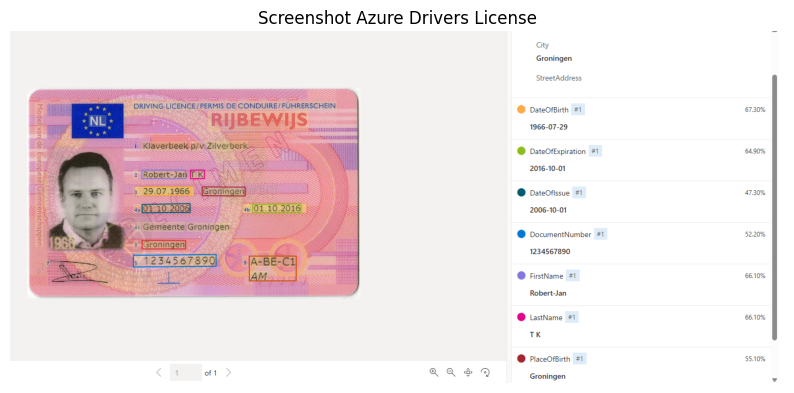

In [ ]:
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
import os
import matplotlib.pyplot as plt
import cv2

# Azure Form Recognizer credentials
endpoint = "https://alpayalec1213.cognitiveservices.azure.com/"
key = "3LmBSsqqx9cxjH3abNllYrX6OpBsRqA4QxbmsxC4EoYmg5raJZrjJQQJ99BEACi5YpzXJ3w3AAALACOGQxzy"

# Document to analyze
image_path = "../Accident Report/Image.png"

# Screenshot to display
screenshot_path = "../Accident Report/Screenshot Azure DriversLicense.png"

# Create Form Recognizer client
client = DocumentAnalysisClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

# Analyze image
with open(image_path, "rb") as f:
    poller = client.begin_analyze_document("prebuilt-idDocument", document=f)
    result = poller.result()

# Print results
for doc in result.documents:
    print("Extracted Fields:")
    for name, field in doc.fields.items():
        value = field.value if field.value else "N/A"
        confidence = round(field.confidence * 100)
        print(f" - {name}: {value} ({confidence}%)")

# Display screenshot image
if os.path.exists(screenshot_path):
    img = cv2.imread(screenshot_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title("Screenshot Azure Drivers License")
    plt.axis('off')
    plt.show()
else:
    print(f" Screenshot not found: {screenshot_path}")


#### **Results**
Really satisfactory results. 

## **CONCLUSION**

After analyzing the results of this task, several conclusions can be drawn. The notebook explored two different approaches for extracting structured information from documents: traditional OCR using Tesseract, and Microsoft Azure's Form Recognizer. It quickly became evident that OCR requires significantly more manual effort, especially in terms of image preprocessing, tuning, and regex-based field extraction. And even with this, the results were still bad in some cases. In contrast, Azure's solution is more streamlined: it handles layout analysis, field detection, and multilingual recognition out-of-the-box, which greatly reduces implementation time and increases reliability.

However, Azure currently does not offer a prebuilt model specifically for license plate recognition. While license plate numbers do appear on driver's licenses and can be extracted using Azure, this is not always reliable since the person may not be driving the car associated with their license. Therefore, the best approach is to use Microsoft Azure Form Recognizer for structured extraction from identity documents and driver’s licenses, while Tesseract OCR will continue to be used for reading license plates directly from vehicle images. This hybrid setup combines the robustness of Azure for personal data with the flexibility of OCR for visual elements not yet supported by prebuilt cloud models.

### **Filling the data in the report.**

In [4]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PyPDF2 import PdfReader, PdfWriter
import io

# Path to your original PDF
input_pdf_path = "Accident Report Form.pdf"
output_pdf_path = "Accident Report Form with Grid.pdf"

# Create a transparent overlay with a coordinate grid
packet = io.BytesIO()
c = canvas.Canvas(packet, pagesize=A4)
width, height = A4

# Draw vertical grid lines and X-axis labels
for x in range(0, int(width), 50):
    c.setFont("Helvetica", 6)
    c.drawString(x + 2, 5, str(x))
    c.line(x, 0, x, height)

# Draw horizontal grid lines and Y-axis labels
for y in range(0, int(height), 50):
    c.setFont("Helvetica", 6)
    c.drawString(2, y + 2, str(y))
    c.line(0, y, width, y)

c.save()
packet.seek(0)

# Read original and overlay PDFs
overlay_pdf = PdfReader(packet)
original_pdf = PdfReader(open(input_pdf_path, "rb"))
output_pdf = PdfWriter()

# Apply the overlay to each page of the original PDF
for i, page in enumerate(original_pdf.pages):
    page.merge_page(overlay_pdf.pages[0])
    output_pdf.add_page(page)

# Save the final PDF with grid
with open(output_pdf_path, "wb") as output_file:
    output_pdf.write(output_file)

print(f"✅ Grid overlay added: {output_pdf_path}")


✅ Grid overlay added: Accident Report Form with Grid.pdf


In [ ]:
import io
from PyPDF2 import PdfReader, PdfWriter
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

# Example OCR or user data for Vehicle A
ocr_data = {
    'date': '24/05/2025',
    'time': '14:30',
    'place': 'Rue Lafayette, Paris',
    'injury': 'yes', 
    'property_damage': 'yes',
    'witnesses': 'No',
    'name_a': 'John Doe',
    'first_name_a': 'John',
    'address_a': '123 Main Street, Paris',
    'phone_number': '0683246393',
    'vat_a': 'yes',
    'make_a': 'Renault Clio',
    'registration_a': 'AB-123-CD',
    'insurer_a': 'MAIF',
    'policy_num': '5789',
    'agent_a': 'Agent X',
    'green_number': '4467841',
    'green_card_until': '12/2025',
    'damage_insured_a': 'yes',
    'driver_name_a': 'Jean Martin',
    'driver_first_name_a': 'Jean',
    'driver_address_a': '456 Rue du Bac, Paris',
    'license_no_a': 'FR987654',
    'license_issued_by_a': 'Paris Prefecture',
    'valid_from': '2016/06',
    'valid_to': '2026/06',
    'initial_impact_a': 'Front',
    'visible_damage_a': 'Front bumper and hood',
    'remarks_a': 'Slippery road, lost control',
    'signature_a': 'John Doe'
}

# Create the overlay canvas
packet = io.BytesIO()
can = canvas.Canvas(packet, pagesize=A4)

# Refined coordinates for Vehicle A fields
can.drawString(30, 755, ocr_data['date'])
can.drawString(120, 755, ocr_data['time'])
can.drawString(180, 755, ocr_data['place'])
can.drawString(538, 755, ocr_data['injury']) #if statement yes or no
can.drawString(140, 725, ocr_data['property_damage']) #if statement yes or no
can.drawString(170, 725, ocr_data['witnesses']) #if statement, exists or does not exist
s

can.drawString(50, 668, ocr_data['name_a'])
can.drawString(62, 653, ocr_data['first_name_a'])
can.drawString(58, 638, ocr_data['address_a'])
can.drawString(140, 598, ocr_data['phone_number'])

can.drawString(250, 580, ocr_data['vat_a'])  #if statement yes or no

can.drawString(62, 548, ocr_data['make_a'])
can.drawString(140, 535, ocr_data['registration_a'])

can.drawString(150, 518, ocr_data['insurer_a'])
can.drawString(58, 495, ocr_data['policy_num'])

can.drawString(90, 482, ocr_data['agent_a'])
can.drawString(80, 455, ocr_data['green_number']) #if statement exists or does not exist
can.drawString(120, 440, ocr_data['green_card_until'])
can.drawString(185, 415, ocr_data['damage_insured_a']) #if statement yes or no

can.drawString(50, 379, ocr_data['driver_name_a'])
can.drawString(60, 362, ocr_data['driver_first_name_a'])
can.drawString(55, 348, ocr_data['driver_address_a'])
can.drawString(90, 330, ocr_data['license_no_a'])
can.drawString(40, 311, ocr_data['license_issued_by_a'])
can.drawString(59, 295, ocr_data['valid_from'])
can.drawString(145, 295, ocr_data['valid_to'])

can.drawString(150, 280, ocr_data['initial_impact_a']) #separate logic needed, first one if its a car, motor, or bigger car, and then another one where its something like "front" "back" "side-left" "side-right" "back-right" "back-left" front-right "front-left"
can.drawString(35, 150, ocr_data['visible_damage_a']) #two, three lines, how do i do this
can.drawString(35, 98, ocr_data['remarks_a'])
can.drawString(245, 60, ocr_data['signature_a'])

can.save()
packet.seek(0)

# Merge overlay with original
existing_pdf = PdfReader("Accident Report Form.pdf")
overlay_pdf = PdfReader(packet)
output = PdfWriter()

original_page = existing_pdf.pages[0]
original_page.merge_page(overlay_pdf.pages[0])
output.add_page(original_page)

# Save the filled PDF
with open("filled_accident_report.pdf", "wb") as f:
    output.write(f)

In [85]:
import io
from PyPDF2 import PdfReader, PdfWriter
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from textwrap import wrap

# Example OCR or user-provided data
ocr_data = {
    'date': '24/05/2025',
    'time': '14:30',
    'place': 'Rue Lafayette, Paris',
    'injury': 'no',
    'property_damage': 'no',
    'witnesses': 'No',
    'name_a': 'John Doe',
    'first_name_a': 'John',
    'address_a': '123 Main Street, Paris',
    'phone_number': '0683246393',
    'vat_a': 'no',
    'make_a': 'Renault Clio',
    'registration_a': 'AB-123-CD',
    'insurer_a': 'MAIF',
    'policy_num': '5789',
    'agent_a': 'Agent X',
    'green_number': '4467841',
    'green_card_until': '12/2025',
    'damage_insured_a': 'no',
    'driver_name_a': 'Jean Martin',
    'driver_first_name_a': 'Jean',
    'driver_address_a': '456 Rue du Bac, Paris',
    'license_no_a': 'FR987654',
    'license_issued_by_a': 'Paris Prefecture',
    'valid_from': '2016/06',
    'valid_to': '2026/06',
    'initial_impact_a': 'car, front-right',
    'visible_damage_a': 'Front bumper and hood have major dents, possible radiator damage',
    'remarks_a': 'Slippery road, lost control',
    'signature_a': 'John Doe'
}

packet = io.BytesIO()
can = canvas.Canvas(packet, pagesize=A4)

# Date, Time, Place
can.drawString(30, 755, ocr_data['date'])
can.drawString(120, 755, ocr_data['time'])
can.drawString(180, 755, ocr_data['place'])

# Injury checkbox
if ocr_data.get('injury', '').lower() == 'yes':
    can.drawString(531, 755, '✓')  # Yes box
else:
    can.drawString(470, 755, '✓')  # No box

# Property damage checkbox
if ocr_data.get('property_damage', '').lower() == 'yes':
    can.drawString(132, 717, '✓')  # Yes box
else:
    can.drawString(70, 717, '✓')  # No box

# Witnesses: just mark if it exists and is not 'no'
if ocr_data.get('witnesses', '').strip().lower() != 'no':
    can.drawString(170, 725, '✓')

# Personal info
can.drawString(50, 668, ocr_data['name_a'])
can.drawString(62, 653, ocr_data['first_name_a'])
can.drawString(58, 638, ocr_data['address_a'])
can.drawString(140, 598, ocr_data['phone_number'])

# VAT checkbox
if ocr_data.get('vat_a', '').lower() == 'yes':
    can.drawString(185, 575, '✓')
else:
    can.drawString(125,575, '✓')
# Vehicle info
can.drawString(62, 548, ocr_data['make_a'])
can.drawString(140, 535, ocr_data['registration_a'])

# Insurance info
can.drawString(150, 518, ocr_data['insurer_a'])
can.drawString(58, 495, ocr_data['policy_num'])
can.drawString(90, 482, ocr_data['agent_a'])

# Green card: only draw if it exists
if ocr_data.get('green_number'):
    can.drawString(80, 455, ocr_data['green_number'])
can.drawString(120, 440, ocr_data['green_card_until'])

# Damage insured checkbox
if ocr_data.get('damage_insured_a', '').lower() == 'yes':
    can.drawString(185, 411, '✓')
else:
    can.drawString(125,411, '✓')

# Driver info
can.drawString(50, 379, ocr_data['driver_name_a'])
can.drawString(60, 362, ocr_data['driver_first_name_a'])
can.drawString(55, 348, ocr_data['driver_address_a'])
can.drawString(90, 330, ocr_data['license_no_a'])
can.drawString(40, 311, ocr_data['license_issued_by_a'])
can.drawString(59, 295, ocr_data['valid_from'])
can.drawString(145, 295, ocr_data['valid_to'])

# Initial point of impact (parse type and location)
impact_info = ocr_data.get('initial_impact_a', '').split(',')
if len(impact_info) == 2:
    vehicle_type = impact_info[0].strip()
    location = impact_info[1].strip()
    can.drawString(150, 280, f"{vehicle_type} / {location}")

# Visible damage - wrap text into 2–3 lines
damage_lines = wrap(ocr_data.get('visible_damage_a', ''), width=60)
y_pos = 150
for line in damage_lines[:3]:
    can.drawString(35, y_pos, line)
    y_pos -= 12

# Remarks
can.drawString(35, 98, ocr_data['remarks_a'])

# Signature
can.drawString(245, 60, ocr_data['signature_a'])

can.save()
packet.seek(0)

# Merge with original PDF
existing_pdf = PdfReader("Accident Report Form.pdf")
overlay_pdf = PdfReader(packet)
output = PdfWriter()

original_page = existing_pdf.pages[0]
original_page.merge_page(overlay_pdf.pages[0])
output.add_page(original_page)

with open("filled_accident_report.pdf", "wb") as f:
    output.write(f)
